In [174]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adagrad


In [2]:
df=pd.read_csv("./data/energydata_complete.csv")

In [3]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

Explained variables: energy consumption ("Appliances" and "lights")

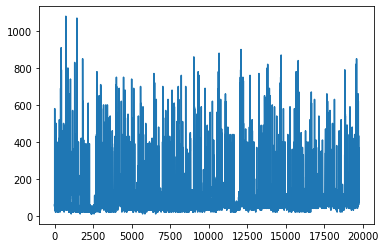

In [5]:
plt.plot(df["Appliances"])
#          .rolling(window=24*6))
plt.show()

# df.rolling(window=24*6)
# plt.plot(df['Appliances']-df["lights"])

Introduce past consumption data?


NSM: time from midnight each day, in seconds

Day of the week, working day or holiday

In [6]:
df["NSM"]=df["date"].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").timestamp()
-datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").replace(hour=0,minute=0,second=0).timestamp())

In [14]:
day=df["date"].apply(lambda x:datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S").weekday())
df=df.merge(pd.get_dummies(day),left_index=True,right_index=True)


In [11]:
days_columns=df.columns[-7:]

In [16]:
df["week-end"]=day.apply(lambda x: x in [5,6]) # à checker

# Feature selection 

The explained variable is the total energy consumption ("Appliances")

The paper proposes two feature selection algorithms.
<ul>
    <li> Boruta algorithm
    <li> Recursive Forrest Elimination
<ul>


In [17]:
y=df[["Appliances"]]
# lights considered as an explanatory variable
X=df.iloc[:,[x not in ["Appliances"] for x in df.columns]]

In [18]:
print(X.shape)
print(y.shape)

(19735, 37)
(19735, 1)


### Scaling 

In [173]:
# scaler=StandardScaler()
# categorical_feature=["week-end"]+list(range(7))
# other_feature=["date"]
# numerical_feature=[f for f in X.columns if f not in categorical_feature+other_feature]
# for f in numerical_feature:
#      X[f]=scaler.fit_transform(X[f])

ValueError: Expected 2D array, got 1D array instead:
array=[3.30126384 3.30126384 3.30126384 ... 0.78103476 0.78103476 0.78103476].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [163]:
X.describe()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,rv1,rv2,NSM,0,1,2,3,4,5,6
count,19735.000000,19735.000000,19735.000000,1.973500e+04,19735.000000,19735.000000,1.973500e+04,19735.000000,1.973500e+04,19735.000000,...,1.973500e+04,1.973500e+04,1.973500e+04,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,0.000000,0.000000,0.000000,-4.608537e-17,0.000000,0.000000,-2.016235e-17,0.000000,1.152134e-17,0.000000,...,1.548180e-17,1.548180e-17,1.836214e-17,0.140765,0.145934,0.145934,0.145934,0.144160,0.138637,0.138637
std,1.000025,1.000025,1.000025,1.000025e+00,1.000025,1.000025,1.000025e+00,1.000025,1.000025e+00,1.000025,...,1.000025e+00,1.000025e+00,1.000025e+00,0.347788,0.353049,0.353049,0.353049,0.351261,0.345576,0.345576
min,-0.479080,-3.048876,-3.326400,-1.934053e+00,-4.903811,-2.526152,-3.218882e+00,-2.817330,-2.618372e+00,-2.310615,...,-1.723389e+00,-1.723389e+00,-1.719764e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.479080,-0.576935,-0.735426,-7.073769e-01,-0.619312,-0.736574,-7.197740e-01,-0.648773,-8.055135e-01,-0.712687,...,-8.616111e-01,-8.616111e-01,-8.776101e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.479080,-0.053904,-0.151556,-1.556007e-01,0.019554,-0.083552,-2.189281e-01,-0.092356,-1.444076e-01,-0.109568,...,-6.234755e-03,-6.234755e-03,-1.139494e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-0.479080,0.568751,0.705400,5.284195e-01,0.697735,0.509650,7.735457e-01,0.609284,7.209424e-01,0.557058,...,8.688952e-01,8.688952e-01,8.548203e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.341722,2.847670,5.805255,4.339172e+00,3.834732,3.473670,3.355616e+00,2.616301,2.778740e+00,3.362774,...,1.725168e+00,1.725168e+00,1.721035e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [23]:
feature_selection=["T_out","Press_mm_hg","RH_out","Windspeed","Tdewpoint","NSM","week-end"]+list(days_columns)x

In [24]:
x_tr=X_train[feature_selection]
y_tr=y_train

# Model fitting 

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR #Radial kernel

In [26]:
from sklearn.model_selection import GridSearchCV

gs_params={"n_jobs":-1,"cv":3,"verbose":True}

In [62]:
gb_params={"learning_rate":[0.1,0.01],"n_estimators":[10,100,200]}

In [75]:
reg_gb=GridSearchCV(GradientBoostingRegressor(),param_grid=gb_params,**gs_params)

In [258]:
reg_gb.fit(x_tr,y_tr)
# reg_rf.fit(x_tr,y_tr)

AttributeError: 'NoneType' object has no attribute 'items'

Je n'ai pas réussi à résoudre ce pb de gridsearch avec gradient boosting, bizarre..

Paper: number of estimators 10900 and maximum tree depth 5

In [78]:
reg_gbm=GradientBoostingRegressor(n_estimators=10900,max_depth=5)
reg_gbm.fit(x_tr,y_tr)
reg_gbm.score(x_tr,y_tr)

/home/default/.local/lib/python3.6/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9998763435436233

clairement overfitt...

In [79]:
x_tt=X_test[feature_selection]
y_tt=y_test

In [80]:
reg_gbm.score(x_tt,y_tt)

0.5132051997220564

## MLP 

### Dataset  & Dataloaders

In [246]:
class AppliancesConsumptionDataset(Dataset):
    def __init__(self,X,y):
        super(AppliancesConsumptionDataset,self).__init__()
        if isinstance(X,pd.DataFrame):
            X=torch.tensor(X.values.astype("float32"))
            y=torch.tensor(y.values.astype("float32"))
        self.X=X
        self.y=y
    def __getitem__(self,i):
        return self.X[i,:],self.y[i]
    def __len__(self):
        return len(self.y)

### MLP class definition

In [252]:
class MLP(torch.nn.Module):
    def __init__(self,layers=[10,1]):
        super(MLP,self).__init__()
        self.layers=layers
        
        f=torch.nn.Linear(layers[0],layers[1])
        for i in range(1,len(layers)-1):
            f=torch.nn.Sequential(f,torch.nn.Linear(layers[i],layers[i+1]))
#         self.functions=[torch.nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)]
        self.f=f
        self.activation=torch.nn.ReLU()
        
    def forward(self,x):
#         y=x.float()
#         for f in self.functions:
#             y=f(y)
#         return self.activation(y)
        return self.activation(self.f(x))

### Training 

In [255]:
def train(X,y,hidden_layers=[10],epochs=100):
    dataset=AppliancesConsumptionDataset(X,y)
    dataloader=DataLoader(dataset,batch_size=128,shuffle=True)
    layers=[X.shape[1]]+hidden_layers+[1]
    model=MLP(layers)
    optimizer=Adagrad(params=model.parameters(),lr=1e-2)
    loss_func=torch.nn.MSELoss()
    loss_history=[]
    for epoch in range(epochs):
        for X,y in dataloader:
            optimizer.zero_grad()
            y_pred=model.forward(X)
            loss=loss_func(y_pred,y)
            loss_history.append(loss)
            loss.backward()
            optimizer.step()
        if epoch %(epochs//10)==0:
            print("Epoch %d"%(epoch))
    return model,loss_history

In [256]:
nn_model,loss_history=train(X[feature_selection],y)

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90


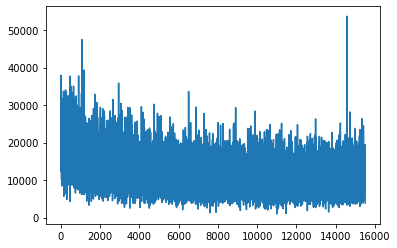

In [257]:
plt.plot(loss_historys_historys_history)